In [2]:
from models.ICA_EM import *
from models.dgp import *
from models.metrics import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
n = 10000
J = 6
I = 5

In [4]:
def norm_funtion(A):
    # [0,0], [1,1] must be one
    A_0 = A[:, 0]/A[0,0]
    return A_0

In [5]:
B = 50
noise_grid = np.linspace(0, 3, 10)
treatments_true = np.zeros((len(noise_grid), B))
treatments_pred = np.zeros((len(noise_grid), B))
ll_score = np.zeros((len(noise_grid), B))
mse_score = np.zeros((len(noise_grid), B))
fscore = np.zeros((len(noise_grid), B))

In [20]:
for i in tqdm.tqdm(range(len(noise_grid))):
    data = dgp(noise_dict= {"loc" : 0, "scale" : noise_grid[i]}, prior= {"loc" : 0, "scale" : 1/np.sqrt(2)})
    for j in range(B):
        data.generate_data(n, I, J, random_state=j)
        est = VarEM(update_sigma=False, true_A= data.mixing_matrix_observed, random_seed = j, tol=1e-4, max_iter = 100)
        est.fit(data.data_observed, J, noise_params={"mean": 0, "std": noise_grid[i] if noise_grid[i] > 0 else 1}, progress_bar=False)
        treatments_true[i, j] = data.treatment_effect
        best_perm, score = f_score(data.mixing_matrix_observed, est.A)
        sorted_A = est.A[:, best_perm]
        treatments_pred[i, j] = norm_funtion(sorted_A)[1]
        ll_score[i, j] = likelihood_score(data.signals, est.Signals, true_paras={"mean": 0, "scale": 1/np.sqrt(2)})
        mse_score[i, j] = mean_squared_error(data.signals, est.Signals)
        fscore[i, j] = score




100%|██████████| 10/10 [3:51:48<00:00, 1390.84s/it] 


In [21]:
# save the results
#for i in range(len(noise_grid)):
#    df = pd.DataFrame({"treatments_true": treatments_true[i], "treatments_pred": treatments_pred[i], "ll_score": ll_score[i], "mse_score": mse_score[i], "fscore": fscore[i]})
#    df.to_csv(f"results/increase_noise/VarEM_{noise_grid[i]}.csv", index=False)


In [6]:
# load the results 
for i in range(len(noise_grid)):
    df = pd.read_csv(f"results/increase_noise/VarEM_{noise_grid[i]}.csv")
    treatments_true[i] = df["treatments_true"].values
    treatments_pred[i] = df["treatments_pred"].values
    ll_score[i] = df["ll_score"].values
    mse_score[i] = df["mse_score"].values
    fscore[i] = df["fscore"].values

<Axes: >

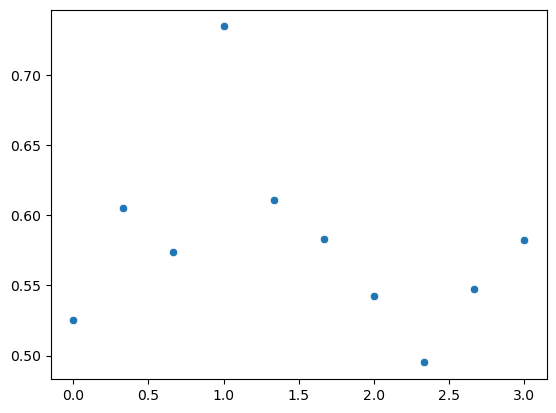

In [9]:
treatment_diff = (treatments_true - treatments_pred)
treatment_mse = np.median(np.abs(treatment_diff), axis=1)
sns.scatterplot(x=noise_grid, y=treatment_mse)

<Axes: >

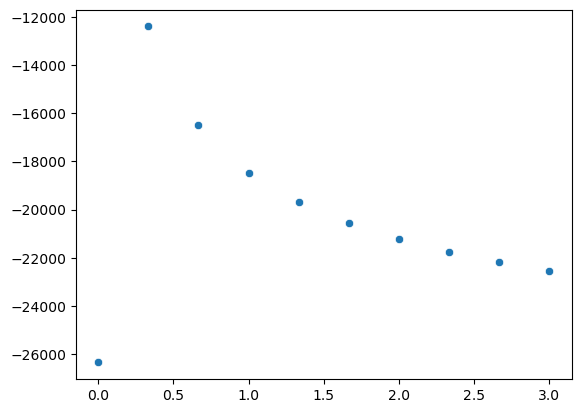

In [10]:
ll_score_mean = np.mean(ll_score, axis=1)
sns.scatterplot(x=noise_grid, y=ll_score_mean)

<Axes: >

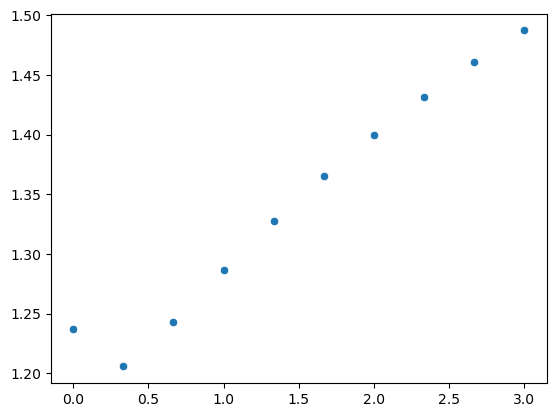

In [11]:
mse_score_mean = np.mean(mse_score, axis=1)
sns.scatterplot(x=noise_grid, y=mse_score_mean)

<Axes: >

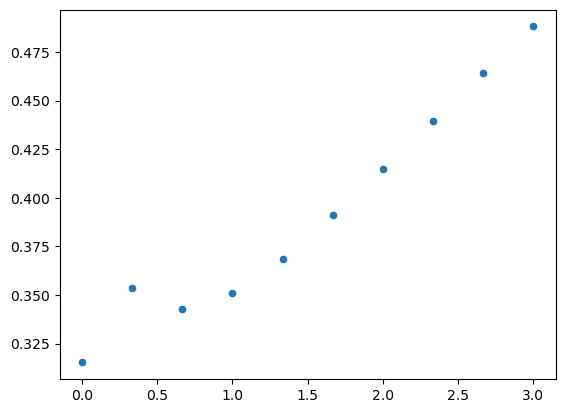

In [12]:
fscore_mean = np.mean(fscore, axis=1)
sns.scatterplot(x=noise_grid, y=fscore_mean)